CREDIT: Adapted from: https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/08-deep-autoencoders.html

In [39]:
import os
import urllib.request
from urllib.error import HTTPError

import numpy 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import torchvision
from pytorch_lightning.callbacks import Callback, LearningRateMonitor, ModelCheckpoint
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torchvision.datasets import CIFAR10
from tqdm.notebook import tqdm
import pandas as pd
from pathlib import Path
import librosa
import librosa.display
import wave
from scipy import signal
from scipy.io import wavfile
import soundfile as sf
from torcheval.metrics import R2Score
import torchaudio
from torchaudio import transforms

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.reset_orig()
sns.set()

# Tensorboard extension (for visualization purposes later)
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = os.environ.get("PATH_DATASETS", "data")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/audio_test")

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Seed set to 42


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [40]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


In [47]:
class AudioDS(Dataset):
    def __init__(self, presets_csv_path):
        self.presets = pd.read_csv(presets_csv_path)
        # Take only the first 100 for debugging
        self.presets = self.presets.head(2999)
    
    def __len__(self):
        return len(self.presets)
    
    def __getitem__(self, idx):
        preset = self.presets.iloc[idx]
        preset_name = preset[0]
        spectrogram_path = Path(f'../../data/spectrograms/128x128/{preset_name}.png')

        # First, check if the image has already been generated
        if not spectrogram_path.exists():
            raise FileNotFoundError(spectrogram_path)

        try:
            # Load the image
            image = torchvision.io.read_image(spectrogram_path)
        except:
            print('error loading image')
            print(preset_name)

        image = image.float() / 255
        # print(image)
        preset = torch.tensor(preset[1:-1])

        return image, preset

In [48]:
# Loading the training dataset. We need to split it into a training and validation part
dataset = AudioDS('..\\..\\data\\presets.csv')
pl.seed_everything(42)
num_train = int(0.9 * len(dataset))
num_val = len(dataset) - num_train
train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [num_train, num_val])
batch_size = 256

# We define a set of data loaders that we can use for various purposes later.

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(num)], dim=0)


Seed set to 42


In [49]:
get_train_images(1)

C:\Users\jayor\AppData\Local\Temp\ipykernel_7172\1055357869.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preset_name = preset[0]
C:\Users\jayor\AppData\Local\Temp\ipykernel_7172\1055357869.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preset = torch.tensor(preset[1:-1])


tensor([[[[0.2196, 0.1255, 0.1255,  ..., 0.0196, 0.0196, 0.0118],
          [0.3608, 0.3216, 0.3216,  ..., 0.1922, 0.1922, 0.1412],
          [0.3961, 0.3373, 0.3373,  ..., 0.2510, 0.2510, 0.2196],
          ...,
          [0.9961, 0.9961, 0.9961,  ..., 0.8980, 0.8980, 0.9059],
          [0.9961, 0.9961, 0.9961,  ..., 0.9216, 0.9216, 0.8902],
          [0.9961, 0.9922, 0.9922,  ..., 0.9569, 0.9569, 0.8784]],

         [[0.0627, 0.0667, 0.0667,  ..., 0.0157, 0.0157, 0.0118],
          [0.0863, 0.0745, 0.0745,  ..., 0.0667, 0.0667, 0.0706],
          [0.1020, 0.0784, 0.0784,  ..., 0.0588, 0.0588, 0.0627],
          ...,
          [0.7765, 0.6471, 0.6471,  ..., 0.3137, 0.3137, 0.3216],
          [0.7569, 0.6392, 0.6392,  ..., 0.3412, 0.3412, 0.3059],
          [0.6667, 0.5882, 0.5882,  ..., 0.4039, 0.4039, 0.2980]],

         [[0.4235, 0.2941, 0.2941,  ..., 0.0863, 0.0863, 0.0706],
          [0.4980, 0.4863, 0.4863,  ..., 0.3961, 0.3961, 0.3255],
          [0.5020, 0.4902, 0.4902,  ..., 0

In [25]:
class Encoder(nn.Module):
    def __init__(self, num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.GELU):
        """Encoder.

        Args:
           num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the encoder network

        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2),  # 32x32 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),  # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),  # 8x8 => 4x4
            act_fn(),
            nn.Flatten(),  # Image grid to single feature vector
            nn.Linear(2 * (16 * 16) * c_hid, latent_dim), # 50, 50
        )
    def forward(self, x):
        return self.net(x)

In [26]:
class Decoder(nn.Module):
    def __init__(self, num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.GELU):
        """Decoder.

        Args:
           num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the decoder network

        """
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(nn.Linear(latent_dim, 2 * (16 * 16) * c_hid), act_fn()) # 50, 50
        self.net = nn.Sequential(
            nn.ConvTranspose2d(
                2 * c_hid, 2 * c_hid, kernel_size=3, output_padding=1, padding=1, stride=2
            ),  # 4x4 => 8x8
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2 * c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),  # 8x8 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(
                c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2
            ),  # 16x16 => 32x32
            nn.Tanh(),  # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 16, 16)
        x = self.net(x)
        return x

In [31]:
class Autoencoder(pl.LightningModule):
    def __init__(
        self,
        base_channel_size: int,
        latent_dim: int,
        encoder_class: object = Encoder,
        decoder_class: object = Decoder,
        num_input_channels: int = 2,
        width: int = 128,
        height: int = 128,
    ):
        super().__init__()
        # Saving hyperparameters of autoencoder
        self.save_hyperparameters()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)
        # Example input array needed for visualizing the graph of the network
        self.example_input_array = torch.zeros(1, num_input_channels, width, height)

    def forward(self, x):
        """The forward function takes in an image and returns the reconstructed image."""
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def _get_reconstruction_loss(self, batch):
        """Given a batch of images, this function returns the reconstruction loss (MSE in our case)."""
        x, _ = batch  # We do not need the labels
        x_hat = self.forward(x)
        # print('x.shape: ', x.shape)
        # print('x_hat.shape: ', x_hat.shape)
        loss = F.mse_loss(x, x_hat, reduction="none")
        loss = loss.sum(dim=[1, 2, 3]).mean(dim=[0])
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.2, patience=20, min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("train_loss", loss, on_step=True, on_epoch=True)
        print('train_loss: ', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("val_loss", loss)

    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("test_loss", loss)

In [32]:
class GenerateCallback(Callback):
    def __init__(self, input_imgs, every_n_epochs=1):
        super().__init__()
        self.input_imgs = input_imgs  # Images to reconstruct during training
        # Only save those images every N epochs (otherwise tensorboard gets quite large)
        self.every_n_epochs = every_n_epochs

    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Reconstruct images
            input_imgs = self.input_imgs.to(pl_module.device)
            with torch.no_grad():
                pl_module.eval()
                reconst_imgs = pl_module(input_imgs)
                pl_module.train()

            # print('input_imgs: ', input_imgs)
            # print('reconst_imgs: ', reconst_imgs)
            # Plot and add to tensorboard
            imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0, 1)
            grid = torchvision.utils.make_grid(imgs, nrow=2, normalize=True, value_range=(0, 1))
            # trainer.logger.experiment.image("reconstruction", grid, global_step=trainer.global_step)
            # save image to disk
            save_path = os.path.join(trainer.logger.log_dir, f"reconstruction_{trainer.current_epoch}.png")
            torchvision.utils.save_image(grid, save_path, nrow=2)

In [33]:
def train(latent_dim, max_epochs=50):
    # Create a PyTorch Lightning trainer with the generation callback
    print('creating trainer')
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "final_model_dim_%i" % latent_dim),
        accelerator="auto",
        devices=1,
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(save_weights_only=True),
            GenerateCallback(get_train_images(8), every_n_epochs=1),
            LearningRateMonitor("epoch"),
        ],
    )
    trainer.logger._log_graph = True  # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    # pretrained_filename = os.path.join(CHECKPOINT_PATH, "cifar10_%i.ckpt" % latent_dim)
    # if os.path.isfile(pretrained_filename):
    #     print("Found pretrained model, loading...")
    #     model = Autoencoder.load_from_checkpoint(pretrained_filename)
    # else:
    print("creating model")
    model = Autoencoder(base_channel_size=32, latent_dim=latent_dim)
    print("training model")
    trainer.fit(model, train_loader, val_loader)
    # Test best model on validation and test set
    print("testing model")
    val_result = trainer.test(model, dataloaders=val_loader, verbose=False)
    # test_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    # result = {"test": test_result, "val": val_result}
    result = {"val": val_result}
    return model, result

In [34]:
model_dict = {}
for latent_dim in [64, 128, 256, 384]:
    model_ld, result_ld = train(latent_dim)
    model_dict[latent_dim] = {"model": model_ld, "result": result_ld}

C:\Users\jayor\AppData\Local\Temp\ipykernel_7172\2580750985.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preset_name = preset[0]
C:\Users\jayor\AppData\Local\Temp\ipykernel_7172\2580750985.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preset = torch.tensor(preset[1:-1])
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


creating trainer
creating model
training model



  | Name    | Type    | Params | Mode  | In sizes         | Out sizes       
----------------------------------------------------------------------------------
0 | encoder | Encoder | 1.2 M  | train | [1, 2, 128, 128] | [1, 64]         
1 | decoder | Decoder | 1.2 M  | train | [1, 64]          | [1, 2, 128, 128]
----------------------------------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.272     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


c:\Users\jayor\miniconda3\envs\synth-reconstruct\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
c:\Users\jayor\miniconda3\envs\synth-reconstruct\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9:  18%|█▊        | 2/11 [00:02<00:10,  0.82it/s, v_num=1]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [24]:
model_dict

{64: {'model': Autoencoder(
    (encoder): Encoder(
      (net): Sequential(
        (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): GELU(approximate='none')
        (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): GELU(approximate='none')
        (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (5): GELU(approximate='none')
        (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (7): GELU(approximate='none')
        (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (9): GELU(approximate='none')
        (10): Flatten(start_dim=1, end_dim=-1)
        (11): Linear(in_features=16384, out_features=64, bias=True)
      )
    )
    (decoder): Decoder(
      (linear): Sequential(
        (0): Linear(in_features=64, out_features=16384, bias=True)
        (1): GELU(approximate='none')
      )
      (net): Sequential(
        (0): ConvTra

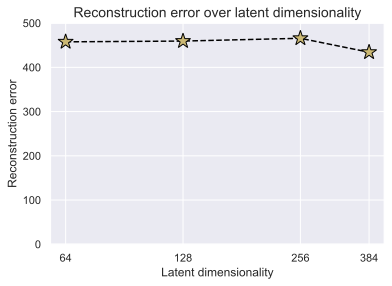

In [25]:
latent_dims = sorted(k for k in model_dict)
val_scores = [model_dict[k]["result"]["val"][0]["test_loss"] for k in latent_dims]

fig = plt.figure(figsize=(6, 4))
plt.plot(
    latent_dims, val_scores, "--", color="#000", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=16
)
plt.xscale("log")
plt.xticks(latent_dims, labels=latent_dims)
plt.title("Reconstruction error over latent dimensionality", fontsize=14)
plt.xlabel("Latent dimensionality")
plt.ylabel("Reconstruction error")
plt.minorticks_off()
plt.ylim(0, 500)
plt.show()

In [31]:
# they all look about the same, so let's just use 128
latent_dim = 128
model_ld, result_ld = train(latent_dim, max_epochs=200)
# Save the model checkpoint. Not strictly necessary because lightning is also saving it, but just to be safe
checkpoint_filename = Path(CHECKPOINT_PATH) / f"final_model_dim_{latent_dim}" / "final_checkpoint.ckpt"
torch.save(model_ld.state_dict(), checkpoint_filename)

C:\Users\jayor\AppData\Local\Temp\ipykernel_17660\986052091.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preset_name = preset[0]
C:\Users\jayor\AppData\Local\Temp\ipykernel_17660\986052091.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preset = torch.tensor(preset[1:-1])
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode  | In sizes         | Out sizes       
----------------------------------------------------------------------------------
0 | encoder | Encod

creating trainer
creating model
training model
Epoch 0:  27%|██▋       | 3/11 [1:35:32<4:14:47,  0.00it/s, v_num=0]
train_loss:  tensor(276.0686, device='cuda:0', grad_fn=<MeanBackward1>)
Epoch 199: 100%|██████████| 11/11 [00:10<00:00,  1.10it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 11/11 [00:10<00:00,  1.09it/s, v_num=0]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



testing model
Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 13.83it/s] 


Predicting preset from latent representations

In [50]:
class Feed_Forward(nn.Module):
    def __init__(self, latent_dim: int, num_classes: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 88),
            nn.ReLU(),
            nn.Linear(88, num_classes),
        )

    def forward(self, x):
        return self.net(x)

In [51]:
class Classifier(pl.LightningModule):
    def __init__(
        self,
        latent_dim: int,
        num_classes: int,
        encoder_model_checkpoint: str,
    ):
        super().__init__()
        # Saving hyperparameters of autoencoder
        self.save_hyperparameters()
        # Load autoencoder and get the encoder only
        self.encoder = Autoencoder.load_from_checkpoint(encoder_model_checkpoint).encoder
        # Put the encoder in evaluation mode
        self.encoder.eval()
        self.feed_forward = Feed_Forward(latent_dim, num_classes)

    def forward(self, x):
        """The forward function takes in an image and returns the reconstructed image."""
        z = self.encoder(x)
        y_hat = self.feed_forward(z)
        return y_hat

    def _get_reconstruction_loss(self, batch):
        """Given a batch of images, this function returns the reconstruction loss (MSE in our case)."""
        x, y = batch  # We do not need the labels
        y_hat = self.forward(x)
        # print('x.shape: ', y.shape)
        # print('x_hat.shape: ', y_hat.shape)
        # Take the first value of y as the only label for prediction
        y = y[:, 2].unsqueeze(1)
        y = y.float()
        y_hat = y_hat.float()
        loss = F.mse_loss(y, y_hat)
        print('loss: ', loss) # 256, 88
        # loss = loss.sum(dim=[1, 2, 3]).mean(dim=[0])
        r2 = R2Score()
        r2.update(y_hat, y)
        r2_score = r2.compute().item()
        print('r2_score: ', r2_score)

        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.2, patience=20, min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("train_loss", loss, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("val_loss", loss)

    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("test_loss", loss)

In [52]:
# Iterate through data in dataloader,
# For each data point, pass it through the decoder, and then pass the output through our simple feedforward network
def train_classifier(latent_dim, num_classes, max_epochs=50, encoder_model_checkpoint=None):
    # Create a PyTorch Lightning trainer with the generation callback
    print('creating trainer')
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "classifier_%i" % latent_dim),
        accelerator="auto",
        devices=1,
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(save_weights_only=True),
            LearningRateMonitor("epoch"),
        ],
    )
    trainer.logger._log_graph = True  # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    print("creating model")
    model = Classifier(latent_dim=latent_dim, num_classes=num_classes, encoder_model_checkpoint=encoder_model_checkpoint)
    print("training model")
    trainer.fit(model, train_loader, val_loader)
    # Test best model on validation and test set
    print("testing model")
    val_result = trainer.test(model, dataloaders=val_loader, verbose=False)
    # test_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    # result = {"test": test_result, "val": val_result}
    result = {"val": val_result}
    return model, result

In [53]:
autoencoder_checkpoint = "C:\\Users\\jayor\\Documents\\repos\\synth-reconstruct\\demo\\autoencoder\\saved_models\\audio_test\\final_model_dim_128\\lightning_logs\\version_0\\checkpoints\\epoch=199-step=2200.ckpt"
num_classes = 1
latent_dim = 128
model_ld, result_ld = train_classifier(latent_dim, num_classes, max_epochs=200, encoder_model_checkpoint=autoencoder_checkpoint)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type         | Params | Mode 
------------------------------------------------------
0 | encoder      | Encoder      | 2.2 M  | eval 
1 | feed_forward | Feed_Forward | 44.5 K | train
------------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.978     Total estimated model params size (MB)
9         Modules in train mode
14        Modules in eval mode
c:\Users\jayor\miniconda3\envs\synth-reconstruct\Lib\site-packages\pytorch_lightning\loggers\tensorboard.py:191: Could not log computational graph to TensorBoard: The `model.example_input_array` attribute is not set or `input_array` was not given.


creating trainer
creating model
training model
Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\jayor\miniconda3\envs\synth-reconstruct\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
C:\Users\jayor\AppData\Local\Temp\ipykernel_7172\1055357869.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preset_name = preset[0]
C:\Users\jayor\AppData\Local\Temp\ipykernel_7172\1055357869.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preset = torch.tensor(preset[1:-1])


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]y.shape:  torch.Size([256, 1])
y_hat.shape:  torch.Size([256, 1])
loss:  tensor(0.2778, device='cuda:0')
r2_score:  -2.2079050540924072
Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 11.11it/s]y.shape:  torch.Size([44, 1])
y_hat.shape:  torch.Size([44, 1])
loss:  tensor(0.2426, device='cuda:0')
r2_score:  -1.9556338787078857
                                                                           

c:\Users\jayor\miniconda3\envs\synth-reconstruct\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
c:\Users\jayor\miniconda3\envs\synth-reconstruct\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   0%|          | 0/11 [00:00<?, ?it/s] y.shape:  torch.Size([256, 1])
y_hat.shape:  torch.Size([256, 1])
loss:  tensor(0.2685, device='cuda:0', grad_fn=<MseLossBackward0>)
r2_score:  -2.2499115467071533
Epoch 0:   9%|▉         | 1/11 [00:00<00:07,  1.27it/s, v_num=18]y.shape:  torch.Size([256, 1])
y_hat.shape:  torch.Size([256, 1])
loss:  tensor(3.0839, device='cuda:0', grad_fn=<MseLossBackward0>)
r2_score:  -35.77628707885742
Epoch 0:  18%|█▊        | 2/11 [00:01<00:06,  1.36it/s, v_num=18]y.shape:  torch.Size([256, 1])
y_hat.shape:  torch.Size([256, 1])
loss:  tensor(0.1103, device='cuda:0', grad_fn=<MseLossBackward0>)
r2_score:  -0.2700643539428711
Epoch 0:  27%|██▋       | 3/11 [00:02<00:05,  1.39it/s, v_num=18]y.shape:  torch.Size([256, 1])
y_hat.shape:  torch.Size([256, 1])
loss:  tensor(0.1766, device='cuda:0', grad_fn=<MseLossBackward0>)
r2_score:  -1.0339221954345703
Epoch 0:  36%|███▋      | 4/11 [00:02<00:04,  1.41it/s, v_num=18]y.shape:  torch.Size([256, 1])
y_hat.


Detected KeyboardInterrupt, attempting graceful shutdown ...


Epoch 9:  18%|█▊        | 2/11 [28:12<2:06:54,  0.00it/s, v_num=1]


NameError: name 'exit' is not defined

In [74]:
def predict(model, preset_name):
    # Put model in evaluation mode
    model.to(device).eval()

    image = torchvision.io.read_image(f'C:\\Users\\jayor\\Documents\\repos\\synth-reconstruct\\demo\\spectrograms_small\\{preset_name}.png')
    image = image.float() / 255
    # put on cuda
    image = image.unsqueeze(0).to(device)

    print('image shape: ', image.shape)

    # Make prediction
    outputs = model(image)

    true = pd.read_csv('../presets.csv')
    # add column names
    true.columns = ['preset'] + [f'param_{i}' for i in range(89)]
    # Get the true values for the preset
    true = true.loc[true['preset'] == preset_name].values[0][1:-1]
    # convert eachv value to a float
    true = [float(i) for i in true]
    print('true: ', true)

    # remove outputs dimension
    
    print('outputs: ', outputs)
    outputs = outputs.squeeze().cpu().detach().numpy()
    # Compare difference between true and predicted values
    diff = numpy.subtract(true, outputs)
    print('diff: ', diff)

In [77]:
predict(model_ld, 'preset_8')

image shape:  torch.Size([1, 4, 128, 128])
true:  [0.1128138127399065, 0.5200412343305395, 0.5048691076285318, 0.0098827374404064, 0.4772178795809715, 0.3488458046957011, 0.183505796322272, 0.3968369440561221, 0.6945592819389794, 0.9378262666849476, 0.6411993774368219, 0.5091637260096223, 0.1697929968357902, 0.9824074326248594, 0.0395036241251579, 0.542074222745996, 0.1334788097457471, 0.6815959430836447, 0.5460944800568336, 0.2981876381147958, 0.4996742123917477, 0.4040111580053628, 0.2657535266387455, 0.3810113867874748, 0.9467943466948706, 0.8345796400867546, 0.6186174672661281, 0.1138328860685606, 0.288204690520314, 0.5296385118662379, 0.1404540087475387, 0.3565403072834314, 0.4598743762441755, 0.8915992751517887, 0.405066379256584, 0.0039768757249234, 0.6975559617956802, 0.5242822477626187, 0.2416376932942164, 0.6048245719420646, 0.2560140778332006, 0.6419355024530109, 0.0380844677095567, 0.6717362138548425, 0.8425245601629546, 0.1023571953117167, 0.8196847660378422, 0.10550245684